In [1]:

import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os
from scipy import optimize
from astroML.linear_model import TLS_logL
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18




In [3]:
# a dictionary of five filters .... 
s82 = np.load('s82drw_shen2011_dic.npy').item()

# make identical declarations of variables 
# as in Chelsea's code ..
f = 'u'
# for f in 'ugriz':
var = s82[f]['SFinf'].data ** 2.0  # variance in mag^2, equal to sigmahat^2*tau/365 = SF_inf^2 
tau = s82[f]['log10tau'].data # where tau is best-fit timescale in days
lRF = s82[f]['lambdaRF'].data # rest-frame wavelength in Angstroms
M_i_corr = s82[f]['M_i'].data # Absolute Magnitude M_i, K-corrected to z=0
mass_bh = s82[f]['mass_BH'].data #  BH mass in log solar masses
redshift = s82[f]['redshift'].data


select = mass_bh > 0 
print('Of ', len(select), ' quasars in that band, ',select.sum() , ' have M_BH')
f = np.log10(np.sqrt(var))[select]  # SF_inf array
x = np.log10(lRF/4000.)[select]     # Rest-wavelength array
y = (M_i_corr+23.)[select]          # Absolute Magnitude M_i, K-corrected to z=0
z = (mass_bh-9.)[select]            # BH mass in 10^9 solar masses
red = np.log10(1.+redshift)[select]  #  redshift array; not needed


lum = y
mbh = z 


# First, remove wavelength trend: 
lampwrsf = - 0.479
fo = f - lampwrsf*x 

# Setup errors 
sigma_lum = 1e-5 #(set arbitrarily small) ; x1
sigma_mbh = 0.2 # BH mass errors in dex   ; x2
sigma_z = 1e-5  # (set arbitrarily small) ; NOT USED 
sigma_y = 0.01  # uncertainty in SFinf   ; y1 



Of  7014  quasars in that band,  4660  have M_BH


## First attempt at using pymc3 : craps out at 25% 

`ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.`

In [6]:

print('Using real data ')
x1_obs = lum
x2_obs = mbh
dx1 = sigma_lum * np.ones_like(x1_obs)
dx2 = sigma_mbh * np.ones_like(x1_obs)
y1_obs = fo
dy1 = sigma_y * np.ones_like(y1_obs)
  
# y1 = A1 * x1 + A2 * x2  + B 

import pymc3 as pm
import numpy as np


#A1_truth = 34
#A2_truth = -23
#C_truth = 345

#x1_obs = np.linspace(10, 10000)
#x1_err = x1*0.01

#x2_obs = np.linspace(100, 100)
#x2_err = x1*0.05

#y_obs = A1_truth * x1_obs + A2_truth * x2_obs + C_truth

#y_err = y_obs * 0.01

with pm.Model() as model:
    
    C = pm.Uniform("C", lower=0, upper=0.5)
    D = pm.Uniform("D", lower=0, upper=0.5)
    A = pm.Uniform("A", lower=-1.5, upper=0)
    x1 = pm.Normal("X1", mu=x1_obs, sd=dx1, shape=len(x1_obs))
    x2 = pm.Normal("X2", mu=x2_obs, sd=dx2, shape=len(x2_obs))
    
    y = C * x1 + D * x2 + A
    
    y = pm.Normal("y", mu=y1_obs, sd=dy1, observed=y1_obs)
    
    trace = pm.sample(1000, njobs=4, chains=10)

Using real data 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [X2, X1, A_interval__, D_interval__, C_interval__]
 25%|██▍       | 372/1500 [00:02<00:06, 171.54it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x107905ed0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/s...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/chris.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x107905ed0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/s...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/chris.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 2, 22, 22, 50, 10, 314280, tzinfo=tzutc()), 'msg_id': '01A0D4CA756A4B448F1F0FC46BF9E5DD', 'msg_type': 'execute_request', 'session': '58508C7FF8DF4343AB128441C946EB51', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '01A0D4CA756A4B448F1F0FC46BF9E5DD', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'58508C7FF8DF4343AB128441C946EB51']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 2, 22, 22, 50, 10, 314280, tzinfo=tzutc()), 'msg_id': '01A0D4CA756A4B448F1F0FC46BF9E5DD', 'msg_type': 'execute_request', 'session': '58508C7FF8DF4343AB128441C946EB51', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '01A0D4CA756A4B448F1F0FC46BF9E5DD', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'58508C7FF8DF4343AB128441C946EB51'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 2, 22, 22, 50, 10, 314280, tzinfo=tzutc()), 'msg_id': '01A0D4CA756A4B448F1F0FC46BF9E5DD', 'msg_type': 'execute_request', 'session': '58508C7FF8DF4343AB128441C946EB51', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '01A0D4CA756A4B448F1F0FC46BF9E5DD', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Import object>, <_ast.Import object>, <_ast.With object>], cell_name='<ipython-input-6-ec33a834e421>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1179f5ef0, execution_..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x117a44420, file "<ipython-input-6-ec33a834e421>", line 30>
        result = <ExecutionResult object at 1179f5ef0, execution_..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x117a44420, file "<ipython-input-6-ec33a834e421>", line 30>, result=<ExecutionResult object at 1179f5ef0, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x117a44420, file "<ipython-input-6-ec33a834e421>", line 30>
        self.user_global_ns = {'A': A, 'C': C, 'Column': <class 'astropy.table.column.Column'>, 'D': D, 'In': ['', "\nimport numpy as np \nfrom scipy.optimize import ...'font.size'] = 15\nrcParams['axes.titlesize'] = 18", '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)"], 'M_i_corr': array([-23.901, -23.399, -24.735, ..., -24.37 , -23.1  , -24.63 ]), 'Out': {}, 'TLS_logL': <function TLS_logL>, 'Table': <class 'astropy.table.table.Table'>, '_': '', ...}
        self.user_ns = {'A': A, 'C': C, 'Column': <class 'astropy.table.column.Column'>, 'D': D, 'In': ['', "\nimport numpy as np \nfrom scipy.optimize import ...'font.size'] = 15\nrcParams['axes.titlesize'] = 18", '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)"], 'M_i_corr': array([-23.901, -23.399, -24.735, ..., -24.37 , -23.1  , -24.63 ]), 'Out': {}, 'TLS_logL': <function TLS_logL>, 'Table': <class 'astropy.table.table.Table'>, '_': '', ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/<ipython-input-6-ec33a834e421> in <module>()
     37     
     38     y = C * x1 + D * x2 + A
     39     
     40     y = pm.Normal("y", mu=y1_obs, sd=dy1, observed=y1_obs)
     41     
---> 42     trace = pm.sample(1000, njobs=4, chains=10)

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'A_interval__': array(0.7303707287405954), 'C_interval__': array(-0.6097497120964113), 'D_interval__': array(-0.3343379279122558), 'X1': array([-2.52720341, -1.37881859, -1.95263939, ..., -2.16756999,
       -1.52069214, -1.11297765]), 'X2': array([ 0.9383003 , -0.86580629, -1.05816444, ...,  0.80364377,
        0.01743815, -0.59903929])}, {'A_interval__': array(-0.9797260720484569), 'C_interval__': array(0.41360800895749983), 'D_interval__': array(-0.21493301393045172), 'X1': array([-4.32983285, -2.55417368, -1.52345087, ..., -2.16945293,
       -1.93278937, -1.16599207]), 'X2': array([ 0.3901514 , -0.535783  ,  0.39967975, ..., -0.5990008 ,
        0.58796334, -0.83488974])}, {'A_interval__': array(-0.7172364948287377), 'C_interval__': array(0.6712612659787762), 'D_interval__': array(0.6432518531794689), 'X1': array([-2.57808396, -1.86795206, -2.1547457 , ..., -3.65936724,
       -2.53233637, -2.06089197]), 'X2': array([ 0.17719096,  0.26118045, -0.97618934, ..., -0.0527175 ,
       -0.60651944,  0.09866377])}, {'A_interval__': array(-0.01955117053780908), 'C_interval__': array(-0.5001821244036244), 'D_interval__': array(-0.7931724107095293), 'X1': array([-3.65539602, -1.34022989, -2.37386128, ..., -3.62536946,
       -1.41462106, -1.1473769 ]), 'X2': array([ 0.79732858, -0.83576057, -1.04293235, ...,  0.05968464,
       -1.0834942 , -0.12350424])}, {'A_interval__': array(0.558402984184408), 'C_interval__': array(-0.5574742731557936), 'D_interval__': array(-0.853599415579285), 'X1': array([-3.8341295 , -1.05525933, -0.99420312, ..., -3.21843314,
       -3.01631164, -0.82626293]), 'X2': array([-0.35666194,  0.659809  , -0.17850377, ...,  0.43660083,
       -0.72657864, -0.390944  ])}, {'A_interval__': array(-0.24619198757023142), 'C_interval__': array(-0.8942478845174622), 'D_interval__': array(-0.7115020110183441), 'X1': array([-2.96952748, -2.25924526, -1.64809513, ..., -2.74131124,
       -1.47812807, -2.02288087]), 'X2': array([ 0.84348994, -0.19437417,  0.42517568, ...,  0.54300635,
       -0.47135631, -0.77809323])}, {'A_interval__': array(-0.5771033573319726), 'C_interval__': array(-0.36849581252441954), 'D_interval__': array(-0.5717948561851687), 'X1': array([-3.60635447, -2.70401453, -0.67262533, ..., -1.80826056,
       -1.43988552, -1.43153956]), 'X2': array([ 0.22685215, -0.06148475,  0.30419657, ...,  0.86578136,
       -0.1076193 , -0.37045915])}, {'A_interval__': array(0.44162195592874554), 'C_interval__': array(0.26544129235260305), 'D_interval__': array(0.7101504132426619), 'X1': array([-4.01967918, -2.53797955, -0.74170204, ..., -2.26534993,
       -1.97575357, -0.90789522]), 'X2': array([ 0.17223971, -0.76325724, -0.1825355 , ...,  0.52386544,
       -1.22633104, -0.4310919 ])}, {'A_interval__': array(-0.478258810943583), 'C_interval__': array(-0.0721510334343316), 'D_interval__': array(-0.8624806204021864), 'X1': array([-3.93277724, -2.08089836, -1.63270142, ..., -1.84637066,
       -2.00877402, -1.06923536]), 'X2': array([-0.07080224, -0.25356494, -0.22776333, ..., -0.2824288 ,
       -0.61488979,  0.35283198])}, {'A_interval__': array(-0.13002489588846378), 'C_interval__': array(-0.2235416817071485), 'D_interval__': array(0.2613303962573603), 'X1': array([-4.04030989, -0.98166557, -1.96724134, ..., -2.56464388,
       -2.25576323, -1.31543725]), 'X2': array([-0.11046558, -0.45046444,  0.16010682, ..., -0.32741006,
        0.28665665, -0.17440656])}], trace=None, chain_idx=0, chains=10, njobs=4, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[923223716, 47507585, 418142163, 57718721, 401375479, 1032805395, 719517166, 1029569358, 406093620, 361212949], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 10, 'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 4, 'progressbar': True, 'random_seed': [923223716, 47507585, 418142163, 57718721, 401375479, 1032805395, 719517166, 1029569358, 406093620, 361212949], 'start': [{'A_interval__': array(0.7303707287405954), 'C_interval__': array(-0.6097497120964113), 'D_interval__': array(-0.3343379279122558), 'X1': array([-2.52720341, -1.37881859, -1.95263939, ..., -2.16756999,
       -1.52069214, -1.11297765]), 'X2': array([ 0.9383003 , -0.86580629, -1.05816444, ...,  0.80364377,
        0.01743815, -0.59903929])}, {'A_interval__': array(-0.9797260720484569), 'C_interval__': array(0.41360800895749983), 'D_interval__': array(-0.21493301393045172), 'X1': array([-4.32983285, -2.55417368, -1.52345087, ..., -2.16945293,
       -1.93278937, -1.16599207]), 'X2': array([ 0.3901514 , -0.535783  ,  0.39967975, ..., -0.5990008 ,
        0.58796334, -0.83488974])}, {'A_interval__': array(-0.7172364948287377), 'C_interval__': array(0.6712612659787762), 'D_interval__': array(0.6432518531794689), 'X1': array([-2.57808396, -1.86795206, -2.1547457 , ..., -3.65936724,
       -2.53233637, -2.06089197]), 'X2': array([ 0.17719096,  0.26118045, -0.97618934, ..., -0.0527175 ,
       -0.60651944,  0.09866377])}, {'A_interval__': array(-0.01955117053780908), 'C_interval__': array(-0.5001821244036244), 'D_interval__': array(-0.7931724107095293), 'X1': array([-3.65539602, -1.34022989, -2.37386128, ..., -3.62536946,
       -1.41462106, -1.1473769 ]), 'X2': array([ 0.79732858, -0.83576057, -1.04293235, ...,  0.05968464,
       -1.0834942 , -0.12350424])}, {'A_interval__': array(0.558402984184408), 'C_interval__': array(-0.5574742731557936), 'D_interval__': array(-0.853599415579285), 'X1': array([-3.8341295 , -1.05525933, -0.99420312, ..., -3.21843314,
       -3.01631164, -0.82626293]), 'X2': array([-0.35666194,  0.659809  , -0.17850377, ...,  0.43660083,
       -0.72657864, -0.390944  ])}, {'A_interval__': array(-0.24619198757023142), 'C_interval__': array(-0.8942478845174622), 'D_interval__': array(-0.7115020110183441), 'X1': array([-2.96952748, -2.25924526, -1.64809513, ..., -2.74131124,
       -1.47812807, -2.02288087]), 'X2': array([ 0.84348994, -0.19437417,  0.42517568, ...,  0.54300635,
       -0.47135631, -0.77809323])}, {'A_interval__': array(-0.5771033573319726), 'C_interval__': array(-0.36849581252441954), 'D_interval__': array(-0.5717948561851687), 'X1': array([-3.60635447, -2.70401453, -0.67262533, ..., -1.80826056,
       -1.43988552, -1.43153956]), 'X2': array([ 0.22685215, -0.06148475,  0.30419657, ...,  0.86578136,
       -0.1076193 , -0.37045915])}, {'A_interval__': array(0.44162195592874554), 'C_interval__': array(0.26544129235260305), 'D_interval__': array(0.7101504132426619), 'X1': array([-4.01967918, -2.53797955, -0.74170204, ..., -2.26534993,
       -1.97575357, -0.90789522]), 'X2': array([ 0.17223971, -0.76325724, -0.1825355 , ...,  0.52386544,
       -1.22633104, -0.4310919 ])}, {'A_interval__': array(-0.478258810943583), 'C_interval__': array(-0.0721510334343316), 'D_interval__': array(-0.8624806204021864), 'X1': array([-3.93277724, -2.08089836, -1.63270142, ..., -1.84637066,
       -2.00877402, -1.06923536]), 'X2': array([-0.07080224, -0.25356494, -0.22776333, ..., -0.2824288 ,
       -0.61488979,  0.35283198])}, {'A_interval__': array(-0.13002489588846378), 'C_interval__': array(-0.2235416817071485), 'D_interval__': array(0.2613303962573603), 'X1': array([-4.04030989, -0.98166557, -1.96724134, ..., -2.56464388,
       -2.25576323, -1.31543725]), 'X2': array([-0.11046558, -0.45046444,  0.16010682, ..., -0.32741006,
        0.28665665, -0.17440656])}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 4
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Feb 22 14:50:16 2019
PID: 61330        Python 3.6.2: /Users/chris/anaconda3/envs/py36/bin/python
...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 923223716, {'A_interval__': array(0.7303707287405954), 'C_interval__': array(-0.6097497120964113), 'D_interval__': array(-0.3343379279122558), 'X1': array([-2.52720341, -1.37881859, -1.95263939, ..., -2.16756999,
       -1.52069214, -1.11297765]), 'X2': array([ 0.9383003 , -0.86580629, -1.05816444, ...,  0.80364377,
        0.01743815, -0.59903929])}), {'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 923223716, {'A_interval__': array(0.7303707287405954), 'C_interval__': array(-0.6097497120964113), 'D_interval__': array(-0.3343379279122558), 'X1': array([-2.52720341, -1.37881859, -1.95263939, ..., -2.16756999,
       -1.52069214, -1.11297765]), 'X2': array([ 0.9383003 , -0.86580629, -1.05816444, ...,  0.80364377,
        0.01743815, -0.59903929])})
        kwargs = {'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=923223716, start={'A_interval__': array(0.7303707287405954), 'C_interval__': array(-0.6097497120964113), 'D_interval__': array(-0.3343379279122558), 'X1': array([-2.52720341, -1.37881859, -1.95263939, ..., -2.16756999,
       -1.52069214, -1.11297765]), 'X2': array([ 0.9383003 , -0.86580629, -1.05816444, ...,  0.80364377,
        0.01743815, -0.59903929])}, draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = 405
        strace = <pymc3.backends.ndarray.NDArray object>
        sampling =  25%|██▍       | 372/1500 [00:02<00:07, 159.27it/s]
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self= 25%|██▍       | 372/1500 [00:02<00:07, 159.26it/s])
    950             except AttributeError:
    951                 raise TqdmDeprecationWarning("""\
    952 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    953 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    954 
--> 955             for obj in iterable:
        obj = <pymc3.backends.ndarray.NDArray object>
        iterable = <generator object _iter_sample>
    956                 yield obj
    957                 # Update and possibly print the progressbar.
    958                 # Note: does not call self.update(1) for speed optimisation.
    959                 n += 1

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'A_interval__': array(0.7303707287405954), 'C_interval__': array(-0.6097497120964113), 'D_interval__': array(-0.3343379279122558), 'X1': array([-2.52720341, -1.37881859, -1.95263939, ..., -2.16756999,
       -1.52069214, -1.11297765]), 'X2': array([ 0.9383003 , -0.86580629, -1.05816444, ...,  0.80364377,
        0.01743815, -0.59903929])}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=923223716)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'A_interval__': array(0.7303709957800429), 'C_interval__': array(-0.6097496294526091), 'D_interval__': array(-0.33433778699894423), 'X1': array([-2.53162208, -1.37950551, -1.95202518, ..., -2.16832046,
       -1.52146533, -1.11343622]), 'X2': array([ 0.93830077, -0.86580611, -1.05816376, ...,  0.80364313,
        0.01743777, -0.59903991])}
        states = [{'depth': 2, 'diverging': False, 'energy': 7786337449932.708, 'energy_error': -443.814453125, 'max_energy_error': -443.814453125, 'mean_tree_accept': 1.0, 'step_size': 8.816283426788176e-06, 'step_size_bar': 1.4739270770833695e-05, 'tree_size': 3, 'tune': True}]
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'A_interval__': array(0.7303709957800429), 'C_interval__': array(-0.6097496294526091), 'D_interval__': array(-0.33433778699894423), 'X1': array([-2.53162208, -1.37950551, -1.95202518, ..., -2.16832046,
       -1.52146533, -1.11343622]), 'X2': array([ 0.93830077, -0.86580611, -1.05816376, ...,  0.80364313,
        0.01743777, -0.59903991])})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([ 0.93830077, -0.86580611, -1.05816376, ...,  0.730371  ,
       -0.33433779, -0.60974963])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([ 0.93830077, -0.86580611, -1.05816376, ...,  0.730371  ,
       -0.33433779, -0.60974963]))
    110         """Perform a single HMC iteration."""
    111         p0 = self.potential.random()
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
--> 115             self.potential.raise_ok()
        self.potential.raise_ok = <bound method QuadPotentialDiagAdapt.raise_ok of...hmc.quadpotential.QuadPotentialDiagAdapt object>>
    116             raise ValueError('Bad initial energy: %s. The model '
    117                              'might be misspecified.' % start.energy)
    118 
    119         adapt_step = self.tune and self.adapt_step_size

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py in raise_ok(self=<pymc3.step_methods.hmc.quadpotential.QuadPotentialDiagAdapt object>)
    185 
    186         self._n_samples += 1
    187 
    188     def raise_ok(self):
    189         if np.any(self._stds == 0):
--> 190             raise ValueError('Mass matrix contains zeros on the diagonal. '
    191                              'Some derivatives might always be zero.')
    192         if np.any(self._stds < 0):
    193             raise ValueError('Mass matrix contains negative values on the '
    194                              'diagonal.')

ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.
___________________________________________________________________________

## PyMC3 : make a test dataset describing a plane ...

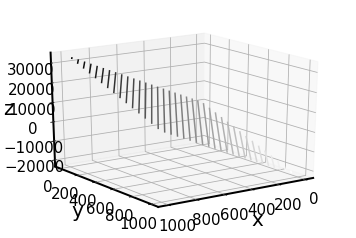

In [9]:
%matplotlib inline

import pymc3 as pm
import numpy as np

A1_truth = 34
A2_truth = -23
C_truth = 345

x1_obs = np.linspace(10, 1000, 100)
x1_err = np.ones_like(x1_obs) * 0.01

x2_obs = np.linspace(10, 1000,100)
x2_err = np.ones_like(x2_obs) * 0.05

y_obs = A1_truth * x1_obs + A2_truth * x2_obs + C_truth

y_err = np.ones_like(y_obs) * 0.01

#https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
from mpl_toolkits import mplot3d
X, Y = np.meshgrid(x1_obs, x2_obs)
Z = A1_truth *X + A2_truth  * Y   + C_truth
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.view_init(20, 55)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
#surf = plt.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)

This craps out with `ValueError: Bad initial energy: nan. The model might be misspecified.`

In [12]:

A1_truth = 34
A2_truth = -23
C_truth = 345

x1_obs = np.linspace(10, 1000, 100)
x1_err = np.ones_like(x1_obs) * 0.01

x2_obs = np.linspace(10, 1000,100)
x2_err = np.ones_like(x2_obs) * 0.05

y_obs = A1_truth * x1_obs + A2_truth * x2_obs + C_truth

y_err = np.ones_like(y_obs) * 0.01

with pm.Model() as model:

    A1 = pm.Uniform("A1", lower=-100, upper=100)
    A2 = pm.Uniform("A2", lower=-100, upper=100)
    C = pm.Uniform("C", lower=10**-3, upper=10**3)
    x1 = pm.Normal("X1", mu=x1_obs, sd=x1_err, shape=len(x1_obs))
    x2 = pm.Normal("X2", mu=x2_obs, sd=x2_err, shape=len(x2_obs))
    
    y = A1 * x1 + A2 * x2 + C
    
    y = pm.Normal("y", mu=y_obs, sd=y_err, observed=y_obs)
    
    trace = pm.sample(1000, njobs=4, tune=1000, chains=10,
                     init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [X2, X1, C_interval__, A2_interval__, A1_interval__]
  0%|          | 0/2000 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x107905ed0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/s...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/chris.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x107905ed0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/s...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/chris.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 2, 22, 22, 52, 55, 16758, tzinfo=tzutc()), 'msg_id': '9DE47FB1F34C4BC1B0EFC7EE1D76FFE1', 'msg_type': 'execute_request', 'session': '58508C7FF8DF4343AB128441C946EB51', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '9DE47FB1F34C4BC1B0EFC7EE1D76FFE1', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'58508C7FF8DF4343AB128441C946EB51']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 2, 22, 22, 52, 55, 16758, tzinfo=tzutc()), 'msg_id': '9DE47FB1F34C4BC1B0EFC7EE1D76FFE1', 'msg_type': 'execute_request', 'session': '58508C7FF8DF4343AB128441C946EB51', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '9DE47FB1F34C4BC1B0EFC7EE1D76FFE1', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'58508C7FF8DF4343AB128441C946EB51'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 2, 22, 22, 52, 55, 16758, tzinfo=tzutc()), 'msg_id': '9DE47FB1F34C4BC1B0EFC7EE1D76FFE1', 'msg_type': 'execute_request', 'session': '58508C7FF8DF4343AB128441C946EB51', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '9DE47FB1F34C4BC1B0EFC7EE1D76FFE1', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')", store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.With object>], cell_name='<ipython-input-12-439727509d79>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 11d2ce748, execution_..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1177a1c90, file "<ipython-input-12-439727509d79>", line 16>
        result = <ExecutionResult object at 11d2ce748, execution_..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1177a1c90, file "<ipython-input-12-439727509d79>", line 16>, result=<ExecutionResult object at 11d2ce748, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1177a1c90, file "<ipython-input-12-439727509d79>", line 16>
        self.user_global_ns = {'A': A, 'A1': A1, 'A1_truth': 34, 'A2': A2, 'A2_truth': -23, 'C': C, 'C_truth': 345, 'Column': <class 'astropy.table.column.Column'>, 'D': D, 'In': ['', "\nimport numpy as np \nfrom scipy.optimize import ...'font.size'] = 15\nrcParams['axes.titlesize'] = 18", '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", '\nimport pymc3 as pm\nimport numpy as np\n\nA1_truth...obs + C_truth\n\ny_err = np.ones_like(y_obs) * 0.01', '\nimport pymc3 as pm\nimport numpy as np\n\nA1_truth...                  linewidth=0, antialiased=False)', "get_ipython().magic('matplotlib inline')\n\nimport...                  linewidth=0, antialiased=False)", '\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_... \n    trace = pm.sample(1000, njobs=4, chains=10)', '\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_... = pm.sample(1000, njobs=4, tune=1000, chains=10)', "\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')"], ...}
        self.user_ns = {'A': A, 'A1': A1, 'A1_truth': 34, 'A2': A2, 'A2_truth': -23, 'C': C, 'C_truth': 345, 'Column': <class 'astropy.table.column.Column'>, 'D': D, 'In': ['', "\nimport numpy as np \nfrom scipy.optimize import ...'font.size'] = 15\nrcParams['axes.titlesize'] = 18", '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', '# a dictionary of five filters .... \ns82 = np.lo...D \nsigma_y = 0.01  # uncertainty in SFinf   ; y1 ', "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", "\nprint('Using real data ')\nx1_obs = lum\nx2_obs =... \n    trace = pm.sample(1000, njobs=4, chains=10)", '\nimport pymc3 as pm\nimport numpy as np\n\nA1_truth...obs + C_truth\n\ny_err = np.ones_like(y_obs) * 0.01', '\nimport pymc3 as pm\nimport numpy as np\n\nA1_truth...                  linewidth=0, antialiased=False)', "get_ipython().magic('matplotlib inline')\n\nimport...                  linewidth=0, antialiased=False)", '\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_... \n    trace = pm.sample(1000, njobs=4, chains=10)', '\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_... = pm.sample(1000, njobs=4, tune=1000, chains=10)', "\nA1_truth = 34\nA2_truth = -23\nC_truth = 345\n\nx1_...hains=10,\n                     init='adapt_diag')"], ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/<ipython-input-12-439727509d79> in <module>()
     24     y = A1 * x1 + A2 * x2 + C
     25     
     26     y = pm.Normal("y", mu=y_obs, sd=y_err, observed=y_obs)
     27     
     28     trace = pm.sample(1000, njobs=4, tune=1000, chains=10,
---> 29                      init='adapt_diag')

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='adapt_diag', n_init=200000, start=[{'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}], trace=None, chain_idx=0, chains=10, njobs=4, tune=1000, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[604895796, 788029010, 112167572, 878719701, 246109313, 920255679, 675129943, 873995686, 1044943727, 160899482], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 10, 'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 4, 'progressbar': True, 'random_seed': [604895796, 788029010, 112167572, 878719701, 246109313, 920255679, 675129943, 873995686, 1044943727, 160899482], 'start': [{'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 4
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Feb 22 14:52:57 2019
PID: 61355        Python 3.6.2: /Users/chris/anaconda3/envs/py36/bin/python
...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 604895796, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}), {'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 604895796, {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])})
        kwargs = {'draws': 2000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=604895796, start={'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=1000, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/2000 [00:00<?, ?it/s]
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/2000 [00:00<?, ?it/s])
    950             except AttributeError:
    951                 raise TqdmDeprecationWarning("""\
    952 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    953 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    954 
--> 955             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    956                 yield obj
    957                 # Update and possibly print the progressbar.
    958                 # Note: does not call self.update(1) for speed optimisation.
    959                 n += 1

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}, trace=None, chain=0, tune=1000, model=<pymc3.model.Model object>, random_seed=604895796)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])}
        states = undefined
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'A1_interval__': array(0.0), 'A2_interval__': array(0.0), 'C_interval__': array(0.0), 'X1': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.]), 'X2': array([   10.,    20.,    30.,    40.,    50.,  ...,   960.,
         970.,   980.,   990.,  1000.])})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([   10.,    20.,    30.,    40.,    50.,  ...,   990.,  1000.,
           0.,     0.,     0.])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([   10.,    20.,    30.,    40.,    50.,  ...,   990.,  1000.,
           0.,     0.,     0.]))
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
    115             self.potential.raise_ok()
    116             raise ValueError('Bad initial energy: %s. The model '
--> 117                              'might be misspecified.' % start.energy)
        start.energy = nan
    118 
    119         adapt_step = self.tune and self.adapt_step_size
    120         step_size = self.step_adapt.current(adapt_step)
    121         self.step_size = step_size

ValueError: Bad initial energy: nan. The model might be misspecified.
___________________________________________________________________________

## PyMC3 from tutorial : descriptive **y ~ x** model 

From https://docs.pymc.io/notebooks/GLM-linear.html  - it works ! 

In [13]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)


with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, x, Intercept]
100%|██████████| 3500/3500 [00:05<00:00, 680.03it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '61369' (I am process '61370')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/chris/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '61369' (I am process '61371')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/chris/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '61370' (I am process '61371')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/chris/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.2-64/lock_dir
The acceptance probability does not

## PyMC3 from tutorial : the likelihood model 
    
    

In [ ]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)

    # Inference!
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling
    
# plot the traces ... 
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

## Adapting tutorial example to two latent variables... 

Takes ~20 mins to run and still fails to converge ... 

In [ ]:
A1_truth = 34
A2_truth = -23
C_truth = 345

x1_obs = np.linspace(10, 1000, 100)
x1_err = np.ones_like(x1_obs) * 0.01

x2_obs = np.linspace(10, 1000,100)
x2_err = np.ones_like(x2_obs) * 0.05

y_err = np.ones_like(y_obs) * 0.01

# y = a + b*x

true_regression_line = A1_truth * x1_obs + A2_truth * x2_obs + C_truth
# add noise
y = true_regression_line + np.random.normal(scale=y_err, size=len(x1_obs))


with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.Normal('sigma', np.mean(y_err),sd=1) # y error 
    C = pm.Normal('Intercept', C_truth, sd=10)
    A1 = pm.Normal('A1', A1_truth, sd=10)
    A2 = pm.Normal('A2', A2_truth, sd=10)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=C + A1 * x1_obs + A2*x2_obs,
                        sd=sigma, observed=y)

    # Inference!
    # tune=1000 from 
    # https://discourse.pymc.io/t/bad-initial-energy-inf-the-model-might-be-misspecified/1431/3 
    trace = pm.sample(5000, chains=10, 
                      cores=2, tune=2000, init='adapt_diag') 
    # draw 3000 posterior samples using NUTS sampling
    
# plot the traces ... 
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();